<a href="https://colab.research.google.com/github/Cheer3142/Focal-Plane-PROP-SIM/blob/main/EvWaCo_Simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Assuming 'Illum_Iband.txt' and 'Illum_Rband.txt' are the full file names
!cp '/content/drive/MyDrive/Narit/PySim/Illum_Iband.txt' '/content/'
!cp '/content/drive/MyDrive/Narit/PySim/Illum_Rband.txt' '/content/'


Mounted at /content/drive


In [ ]:
import numpy as np
from numpy.fft import *
import matplotlib.pyplot as plt
import pandas as pd
from colorsys import hls_to_rgb
from matplotlib.animation import FuncAnimation
import scipy.special as sp

In [ ]:
def telescope_pupil(x, y, r, matrix_size, c, Phi=None):
    match c:
        case 0:
            print('Circular Aperture')
            return circ(x, y, r, matrix_size)
        case 1:
            print('Elliptical Aperture')
            return ellipse(arr, Phi)
        case default:
            raise Exception('Please indicate type of apodization')

In [ ]:
def apod(sigma, c, arr_x, arr_y):
    match c:
        case 0:
            print('No apodizer')
            return np.ones(arr_x.shape)
        case 1:
            print('Gaussian apodizer', end=' ')
            return gaussian(arr_x, arr_y, sigma)
        case default:
            raise Exception('Please indicate type of apodization')

In [ ]:
def circ(x, y, r, matrix_size):
    matrix  = np.zeros((matrix_size, matrix_size))
    inside_circle = (X - 0)**2 + (Y - 0)**2 <= r**2

    # Set the values to 1 where inside the circle
    matrix[inside_circle] = 1
    return matrix

In [ ]:
def circ_o(arr):
    arr     = np.zeros(arr.shape)
    center  = (arr.shape[0]-1)/2

    for x in range(arr.shape[0]):
        for y in range(arr.shape[0]):
            if ((x-center)**2 + (y-center)**2 - center**2) <= 0:
                arr[x][y] = 1
    return arr

In [ ]:
def ellipse(arr, Phi):
    print("Under Implemented!!!!")

In [ ]:
def gaussian(x, y, sig):
    # print(arr.shape)
    forder  = 1.0 / (sig[0]*sig[1] * np.sqrt(2.0 * np.pi))
    soder_x = -np.power((x - x.mean()) / (sig[0] * np.sqrt(2.0)), 2.0)
    soder_y = -np.power((y - y.mean()) / (sig[1] * np.sqrt(2.0)), 2.0)
    sorder  = np.exp((soder_x+soder_y) / 2)

    #print(sorder.max(), sorder.min(), x.mean(), y.mean())
    return sorder

In [ ]:
def illum_profile(band):
    match band:
        case 800:
            fname   = 'Illum_Iband.txt'
            data    = np.genfromtxt(fname, delimiter=' ')
            lambda_range = data[:,0]
            irrad_val    = data[:,1]/100

            print('Accessing >>', fname)
            return irrad_val, lambda_range
        case 700:
            fname   = 'Illum_Rband.txt'
            data    = np.genfromtxt(fname, delimiter=' ')
            lambda_range = data[:,0]
            irrad_val    = data[:,1]/100

            print('Accessing >>', fname)
            return irrad_val, lambda_range
        case default:
            raise Exception('Please indicate illuminate profile')

In [ ]:

### Experimental Parameters ###
f2 = 150e-3     # focal Length of lens L2 focusing the beam on the occulting mask, scalar
f3 = 150e-3     # focal Length of lens L3 collimating the beam and imaging the pupil on the Lyot Stop, scalar
f4 = 250e-3     # focal Length of lens L4 imaging the beam on the detector, scalar

n1 = 1.5108     # PMask optical index, scalar
n2 = 1          # Air thickness optical index, scalar
n3 = 1.5108     # LMask optical index, scalar

Rpupil          = 2e-3              # Pupil radius in m, scalar;
RadiusLyot      = 1.6250e-3         # Lyot Stop radius in m, scalar;

d_pixel     = 16e-6             # pixel size of the camera, in companion channel
npts        = 2**12
wavl        = 700
lambda_cen  = wavl*1e-9         # convert to m (central wavelength)

### Setting up ###
D_pupil     = 2*Rpupil          # Pupil diameter
S           = 2*D_pupil         # support

### Initial Paramaters (Grid) ###
sigma               = 0.1
sigma               = (sigma, sigma)
x                   = np.linspace(-S, S*(1-2/npts), npts)
y                   = x

xg                   = np.linspace(-1, 1, npts)
yg                   = xg
XG, YG               = np.meshgrid(xg, yg)

X, Y                 = np.meshgrid(x, y)         # definition of X and Y matrixes , indexing='ij'
R                    = np.sqrt(X**2+Y**2)        # definition of radial coordinate
R_norm               = R/Rpupil
theta 	             = np.arctan2(Y,X)
rho 	               = R_norm
grid_center          = round((npts-1)/2)
hroi                 = 50
irrad_val, lambda_range = illum_profile(wavl)
lambda_range            = lambda_range*1e-9         # wl nm to m

### Telescope Pupil aperture/apodization ###
T_AS 	               = telescope_pupil(x, y, Rpupil, npts, 0)
T_apod 	            = apod(sigma, 0, XG, YG)      # print(T_apod.max(), T_apod.min())
T_Pupil              = T_apod*T_AS


Accessing >> Illum_Rband.txt
Circular Aperture
No apodizer


In [ ]:
### Amplitude incident on the coronagraphic maks ###
df	    = 1/(2*S)
nu	    = df*np.array(range(int(-npts/2), int(npts/2), 1))
eta	    = df*np.array(range(int(-npts/2), int(npts/2), 1))

### 2D Map of the pupil plane ###
x_D 	                = x/D_pupil
y_D 	                = y/D_pupil
x_image	            = nu*lambda_range[200]*f2
y_image	            = eta*lambda_range[200]*f2
X_image, Y_image    = np.meshgrid(x_image, y_image)
R_image		               = np.sqrt(X_image**2+Y_image**2)

In [ ]:
%%capture

from matplotlib import rc
rc('animation', html='html5')

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
fig.suptitle('Focal Plane', fontsize = 14)

def update(i):
    # T_AS 	             = telescope_pupil(x, y, Rpupil, npts, 0)
    fsigma               = (i+1)/100
    fsigma               = (fsigma, fsigma)
    T_apod 	             = apod(fsigma, 1, XG, YG)      # print(T_apod.max(), T_apod.min())
    T_Pupil              = T_apod*T_AS

    #for i in range(len(lambda_range)):
    Uo 	    = 1 # irrad_val[i]
    E1 	    = Uo*T_Pupil
    # print(i)

    # print('\nλ='+'{:.2f}'.format(lambda_range[i]), end ='\t')
    ax[0].cla()
    ax[1].cla()

    E2    = fftshift(fft2(E1))
    img   = np.abs(E2)**2
    ax[0].imshow(np.log(img)[grid_center-hroi:grid_center+hroi,
                                grid_center-hroi:grid_center+hroi])
    # ax[0].set_title('$\lambda$ = '+'{:.2f}'.format(lambda_range[i]))
    ax[0].set_title('$\sigma$ = '+'{:.2f}'.format(fsigma[0]))

    ax[1].plot(x, E1[grid_center])
    ax[1].set_title('Telescope Pupil Cross-Section')

anim = FuncAnimation(fig, update, frames=50,
                     blit=False, repeat=True)
# plt.show()
anim

In [ ]:
anim

Circular Aperture
Gaussian apodizer 

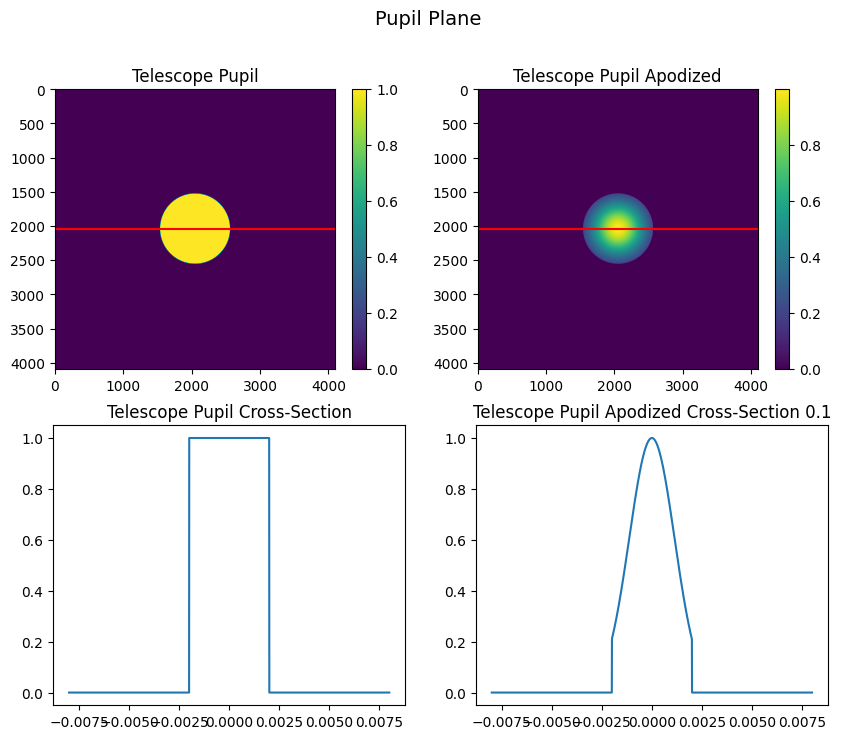

In [ ]:
### Telescope Pupil aperture/apodization ###
T_AS 	               = telescope_pupil(x, y, Rpupil, npts, 0)
T_apod 	            = apod(sigma, 1, XG, YG)      # print(T_apod.max(), T_apod.min())
T_Pupil              = T_apod*T_AS


fig = plt.figure(figsize=(10,8))
fig.suptitle('Pupil Plane', fontsize = 14)

plt.subplot(2, 2, 1)
plt.imshow(T_AS)
plt.axhline(grid_center, color = 'r')
plt.title('Telescope Pupil')
plt.colorbar()

plt.subplot(2, 2, 2)
plt.imshow(T_Pupil)
plt.axhline(grid_center, color = 'r')
plt.title('Telescope Pupil Apodized')
plt.colorbar()

plt.subplot(2, 2, 3)
plt.plot(x, T_AS[grid_center])
plt.title('Telescope Pupil Cross-Section')

plt.subplot(2, 2, 4)
plt.plot(x, T_Pupil[grid_center])
plt.title('Telescope Pupil Apodized Cross-Section {}'.format(sigma[0]))
plt.show()

In [ ]:
### Amplitude of the incoming wave
Uo 	            = irrad_val[200]        # Uo = irrad_val[200]
E1              = Uo*T_Pupil            # Electric field transmitted by the pupil
E2              = fftshift(fft2(E1))    # Complex amplitude at the Occulting mask level.
Irr_Occult_Mask	          = np.abs(E2)**2
Irr_Occult_Mask_norm	    = Irr_Occult_Mask/Irr_Occult_Mask.max()
# print(Irr_Occult_Mask_norm.max())
# print('λ='+'{:.2f}'.format(lambda_range[200]), end ='\t')

In [ ]:
Irr_Occult_Mask_norm

array([[2.42539313e-10, 1.77042160e-10, 6.29722702e-11, ...,
        8.32151087e-12, 6.29722702e-11, 1.77042160e-10],
       [1.77042160e-10, 1.20946326e-10, 3.04218888e-11, ...,
        3.83254370e-14, 2.96345429e-11, 1.20390486e-10],
       [6.29722702e-11, 3.04218888e-11, 1.36116799e-12, ...,
        3.94333727e-11, 2.44476510e-13, 2.96345429e-11],
       ...,
       [8.32151087e-12, 3.83254370e-14, 3.94333727e-11, ...,
        1.65318956e-10, 4.02246724e-11, 5.94631846e-13],
       [6.29722702e-11, 2.96345429e-11, 2.44476510e-13, ...,
        4.02246724e-11, 1.36116799e-12, 3.04218888e-11],
       [1.77042160e-10, 1.20390486e-10, 2.96345429e-11, ...,
        5.94631846e-13, 3.04218888e-11, 1.20946326e-10]])

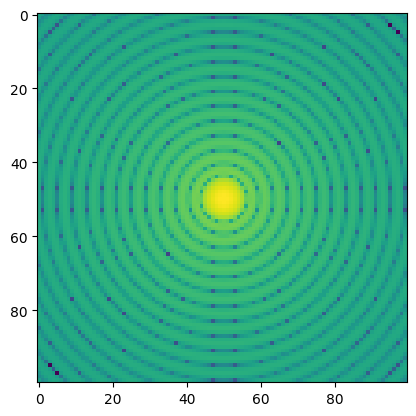

In [ ]:
fig, ax     = plt.subplots()

ax.imshow(np.log(Irr_Occult_Mask_norm)[grid_center-hroi:grid_center+hroi,
                                grid_center-hroi:grid_center+hroi])
# ax.imshow(np.log(img/img.max()))
# plt.title('$\lambda$ = '+'{:.2f}'.format(lambda_range[200]))
plt.show()


<ipython-input-23-56f0447aeb2d>:9: RuntimeWarning: invalid value encountered in divide
  Model		= (sp.jv(1, U)/U)**2                                            # Airy pattern function


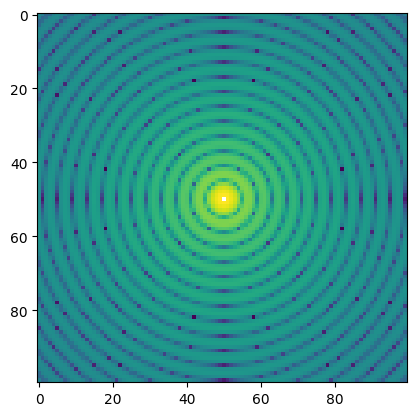

In [ ]:
### Representation in the hypothenuse referential oriented at 45 deg wrt incident beam: ###
xproj		= x_image/np.cos(45/180*np.pi)
Xproj, Yproj 	= np.meshgrid(xproj, y_image)
R_image_proj    = np.sqrt(Xproj**2+Yproj**2)


### Comparison with theoretical model of Airy function ###
U     		= np.pi*D_pupil*R_image/(lambda_range[200]*f2)  # variable definition
Model		= (sp.jv(1, U)/U)**2                                            # Airy pattern function
Model_norm	= Model/Model.max()                                 # normalization by maximum
plt.imshow(np.log(Model)[grid_center-hroi:grid_center+hroi,
                                grid_center-hroi:grid_center+hroi])
plt.show()